This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [96]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [97]:
%matplotlib notebook

In [98]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments_calibrate_angle'
imageroot = 'case4.0'
Calibrationfile = 'Calibration.nml'

/Users/Noah/Documents/GitHub/ice2021/Zimmer/2023-07-03/case4.0 (calibration)
oah/Documents/GitHub/ice2021/Zimmer/2023-07-03/case4.0 (calibration)


In [99]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments_calibrate_angle_retrieved.npz
Segments_calibrate_angle_roughness.jpg
Segments_calibrate_angle_roughness.txt


In [100]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [101]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,'A')
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/case4.0-A.bmp
SEMimages/case4.0-B.bmp
SEMimages/case4.0-C.bmp
SEMimages/case4.0-D.bmp
Filename, dx and dy SEMimages/case4.0-A.bmp 0.9921875 0.9921875


In [102]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 10.297046733516972
Correlation of detectors A-D for each segment
for segment  0
nx= 41
ny= 21
0 1 -6.565078866811041
0 2 1.6560206033237015
0 3 1.7204761711180798
1 2 -1.5187404896737615
1 3 -5.507103642173521
2 3 -3.207881244485553
Correlation score = 9.577471915949648



<IPython.core.display.Javascript object>


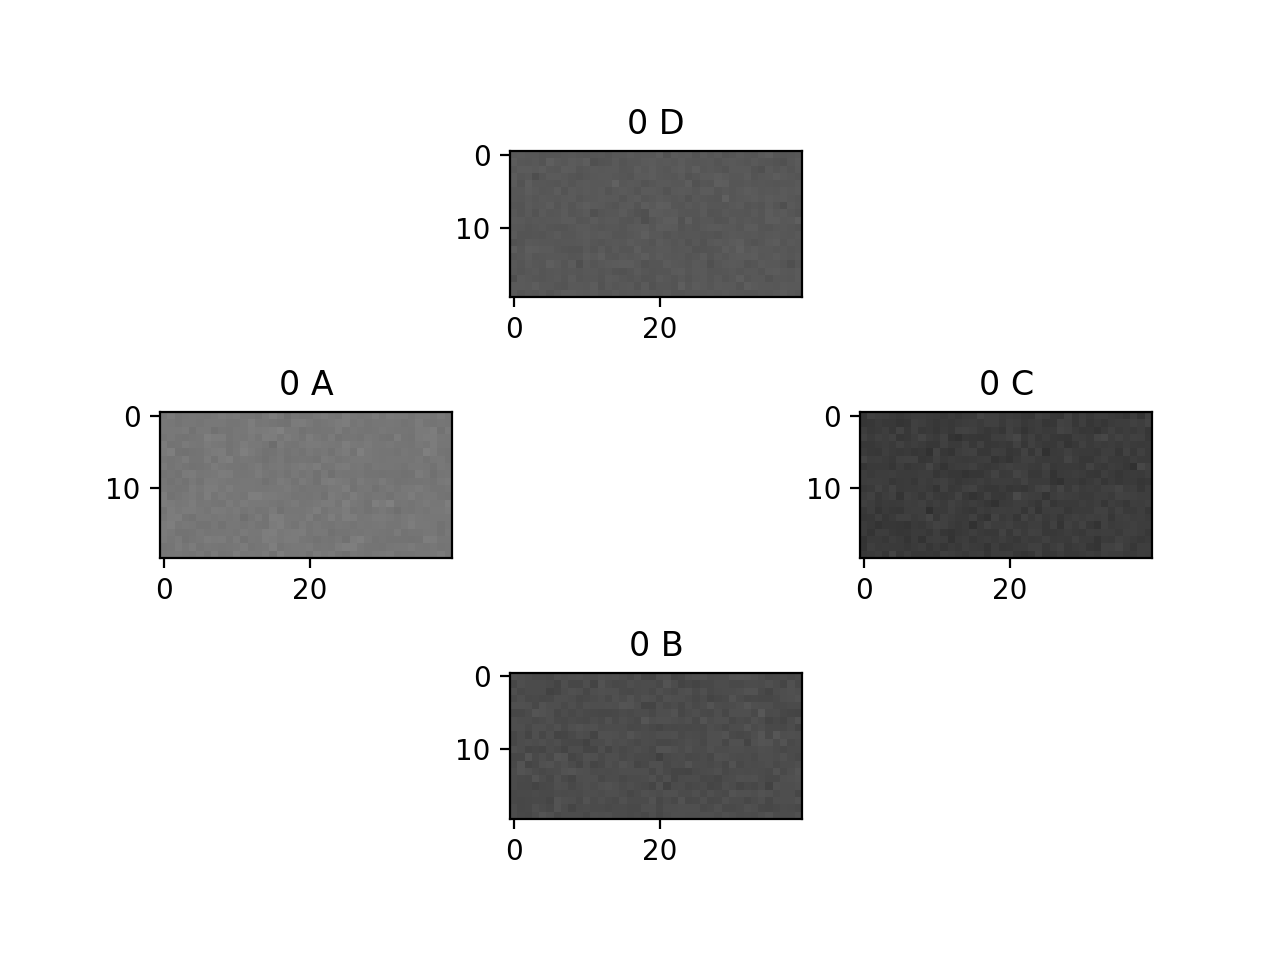

for segment  1
nx= 41
ny= 21
0 1 3.4932432038526993
0 2 -5.6085167998250185
0 3 -4.11954926983972
1 2 0.0253787659661748
1 3 -0.703643785733149
2 3 0.7721073409012285
Correlation score = 7.856258865812399



<IPython.core.display.Javascript object>


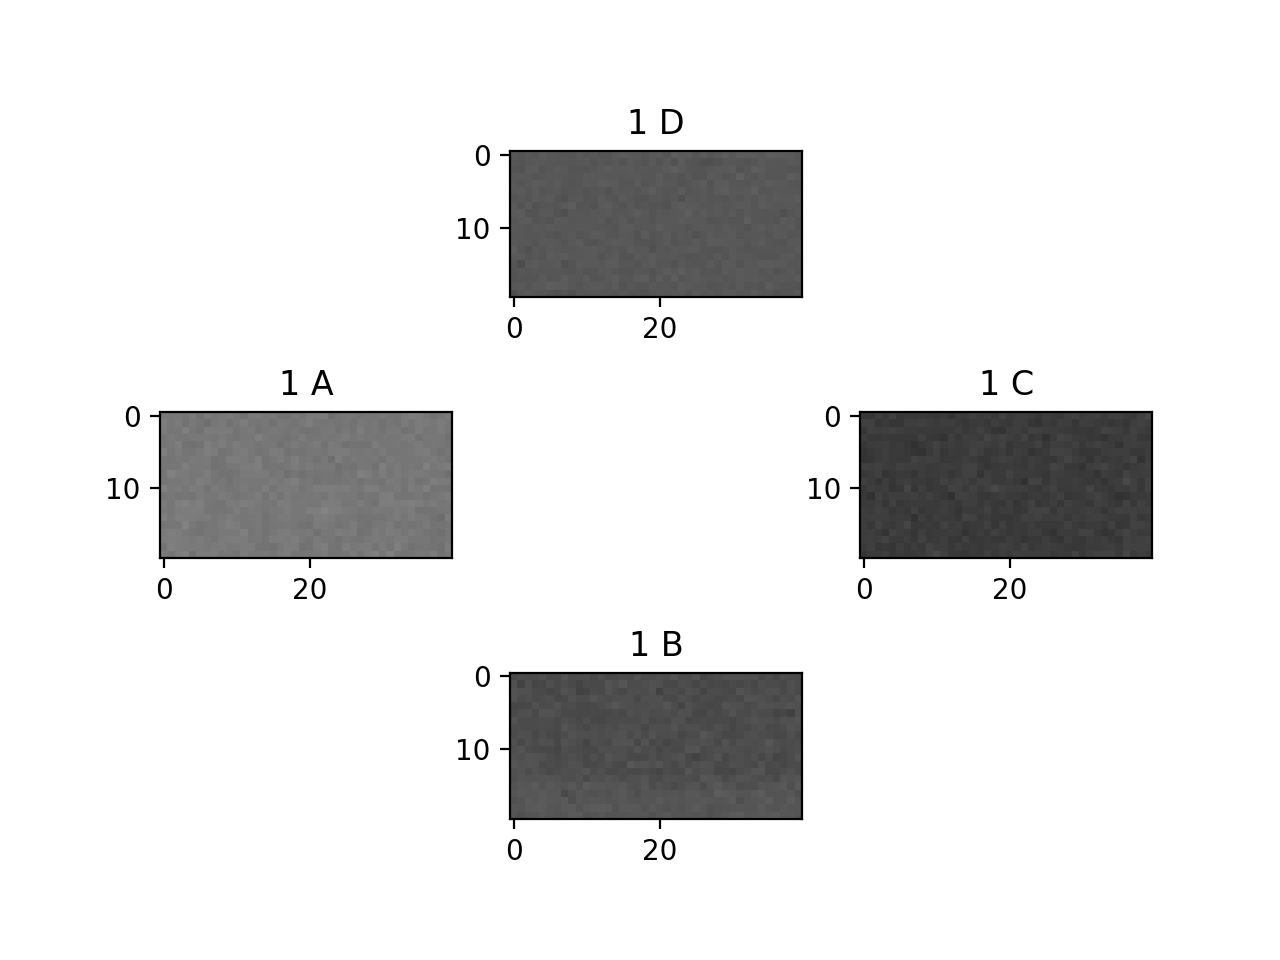

for segment  2
nx= 41
ny= 21
0 1 6.740043933092919
0 2 -8.226204101841391
0 3 -1.4665514027811208
1 2 10.952569259041159
1 3 -18.033600869973313
2 3 -8.10545520639825
Correlation score = 25.022336760916204



<IPython.core.display.Javascript object>


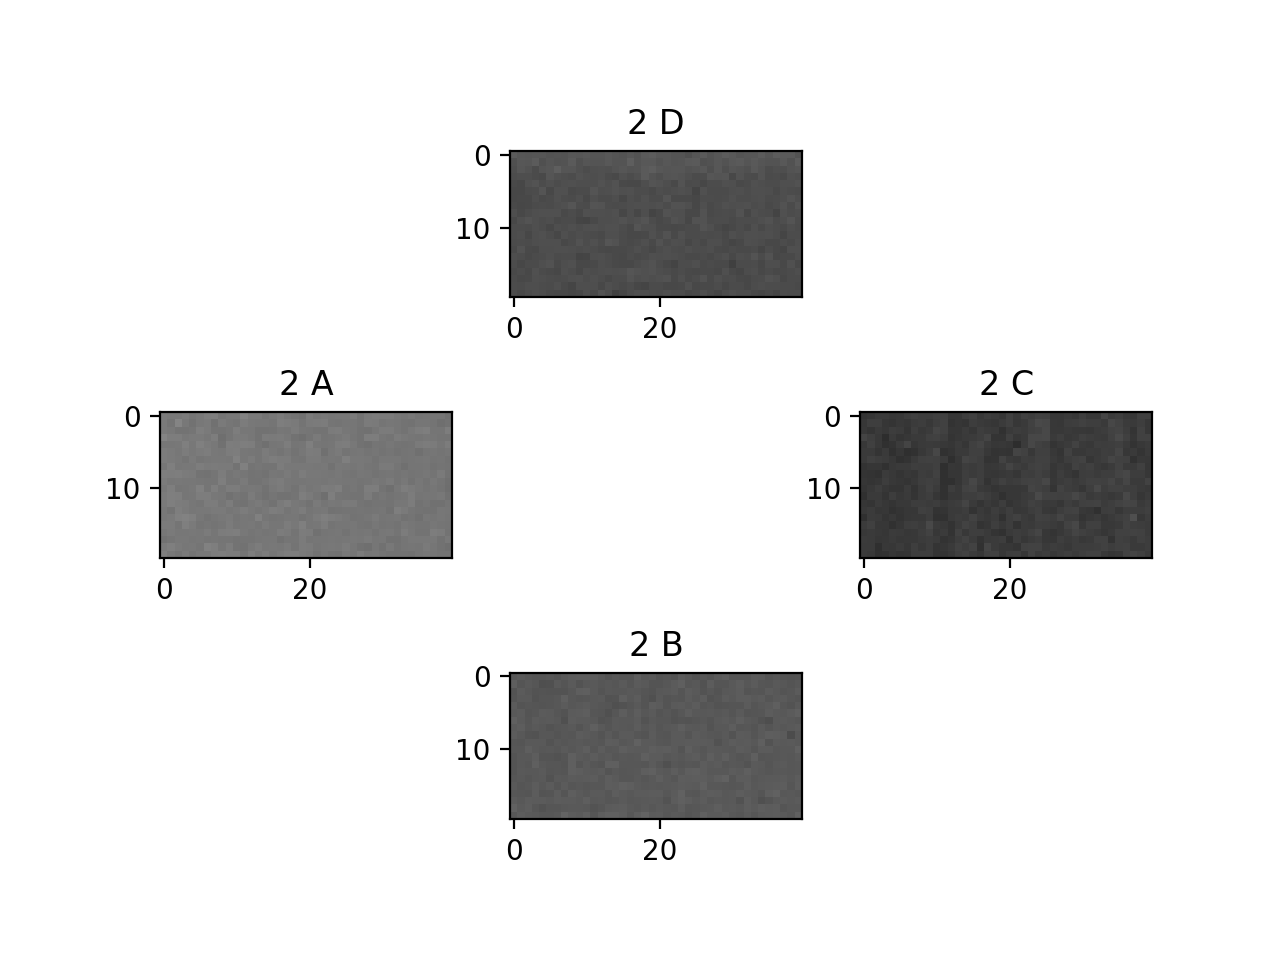

for segment  3
nx= 41
ny= 21
0 1 -1.8751687965611243
0 2 -16.11928370602649
0 3 -1.4301959918742608
1 2 7.163977109171288
1 3 -7.494875342535911
2 3 -3.421384421677148
Correlation score = 19.611084150753086



<IPython.core.display.Javascript object>


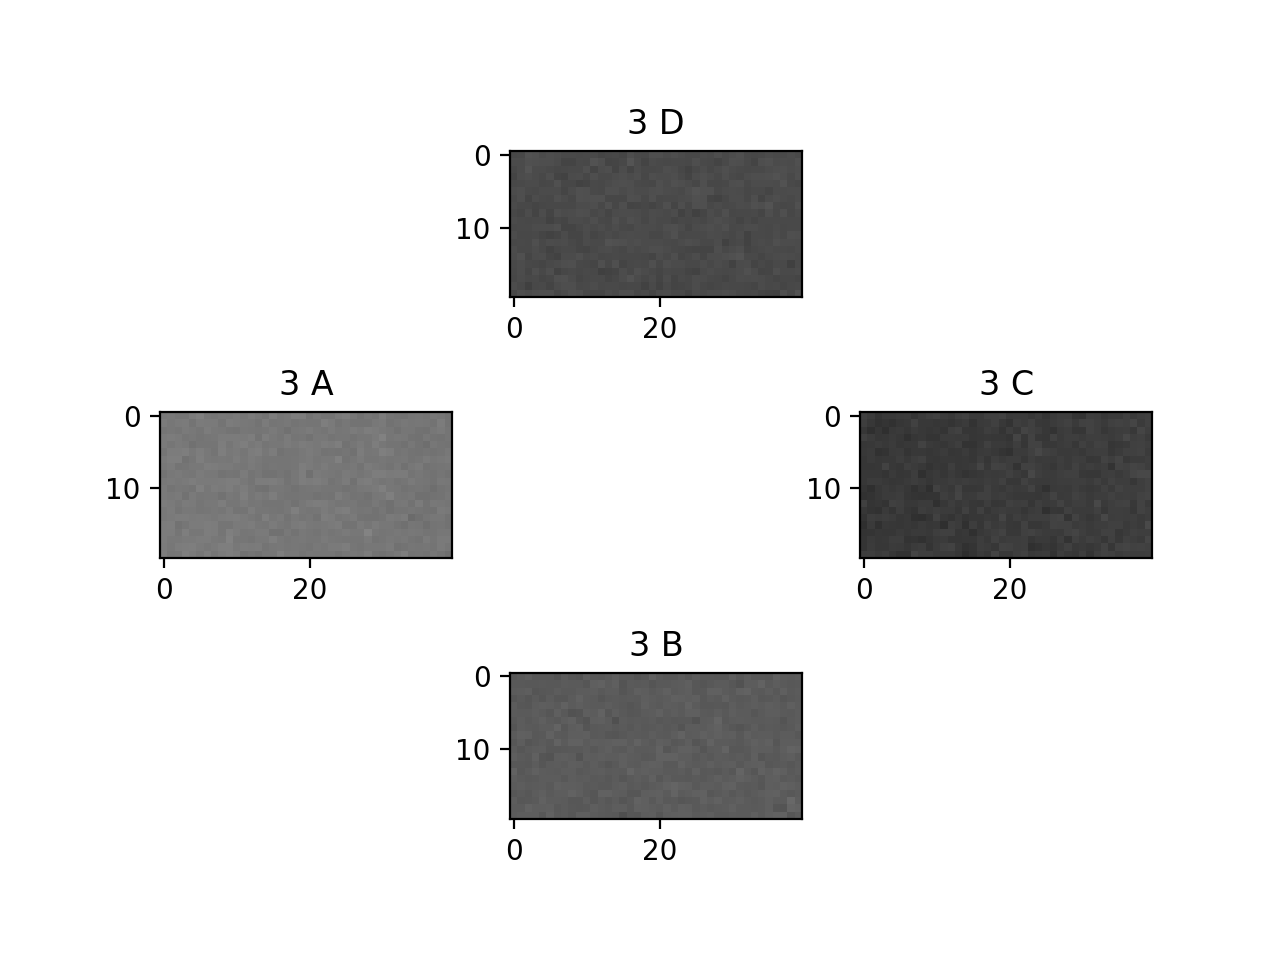

for segment  4
nx= 41
ny= 21
0 1 3.8157650820382596
0 2 -13.949462698800916
0 3 -1.7556102796080453
1 2 9.720392093754278
1 3 -8.268643856321777
2 3 1.1951607389164085
Correlation score = 19.40398523683374



<IPython.core.display.Javascript object>


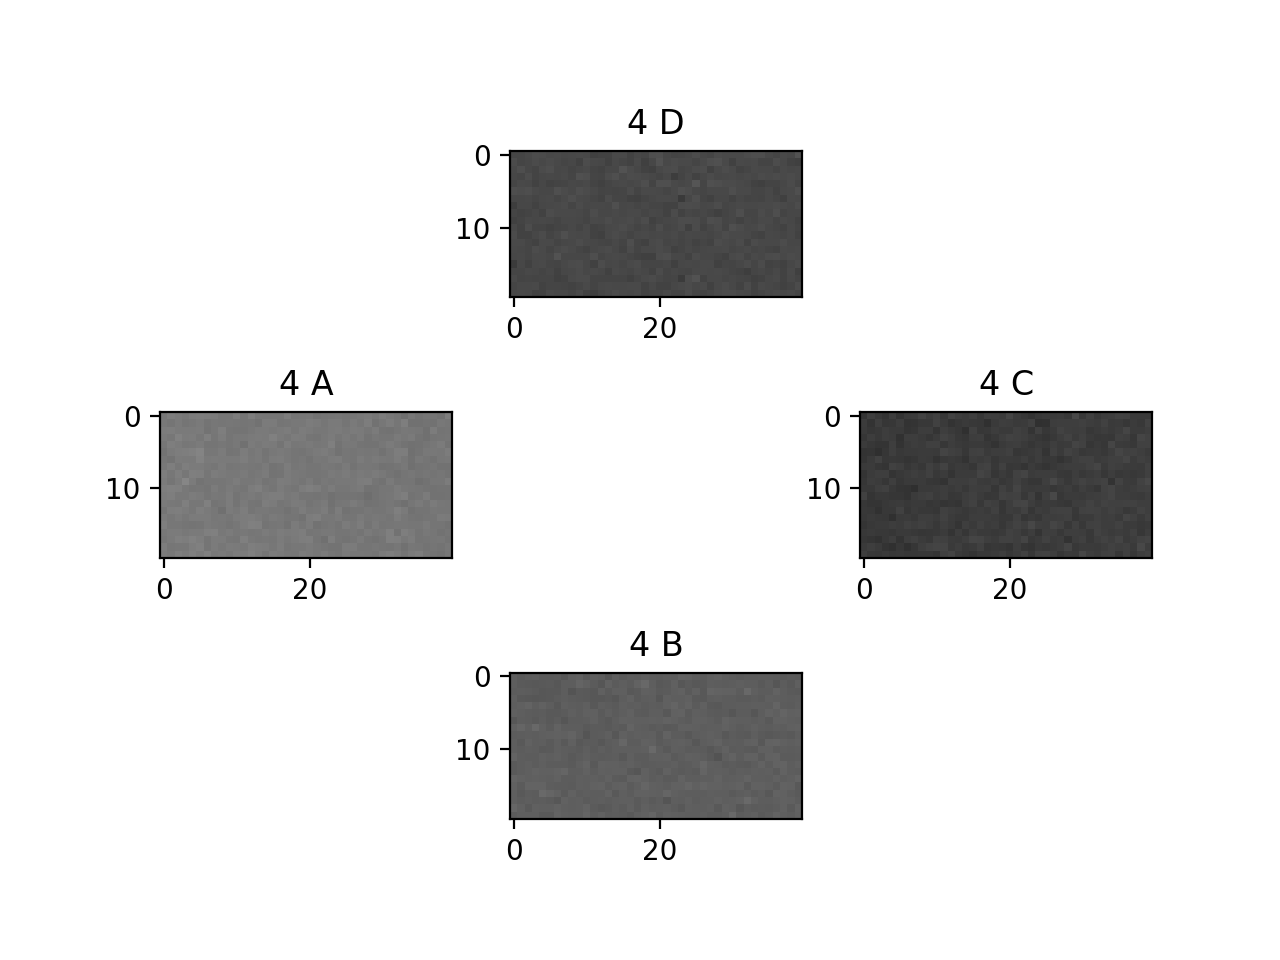

for segment  5
nx= 41
ny= 21
0 1 -9.105959996185268
0 2 -12.613326081963248
0 3 -1.3378024525286847
1 2 7.038617124974611
1 3 -12.812069949946967
2 3 -0.8040731770525621
Correlation score = 21.404252353502745



<IPython.core.display.Javascript object>


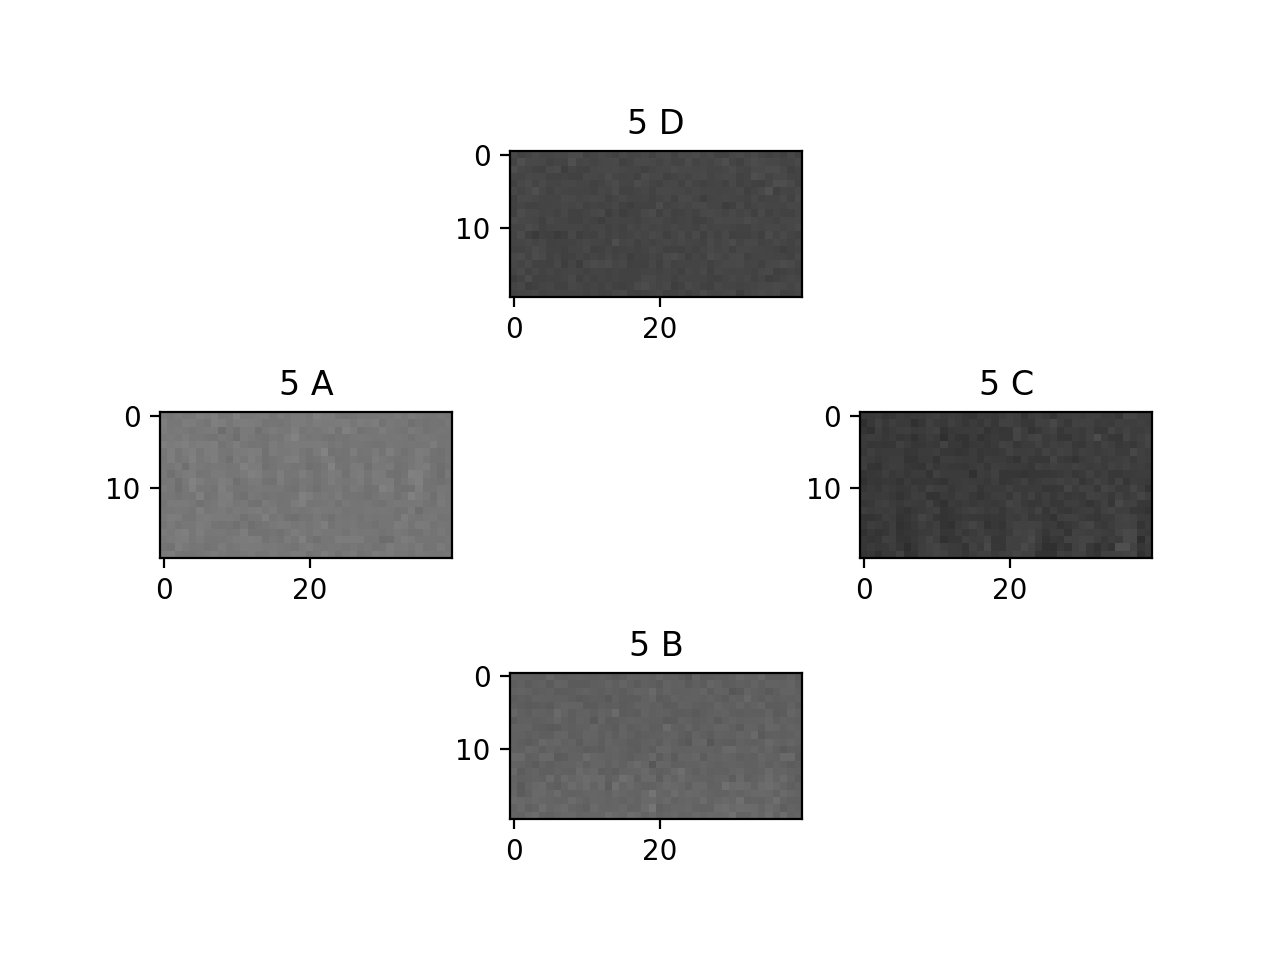

for segment  6
nx= 41
ny= 21
0 1 0.995116972386287
0 2 -1.0277993959486658
0 3 -0.7668334025315346
1 2 4.376629167892002
1 3 -17.358186600253696
2 3 -13.97600250297425
Correlation score = 22.76894450210405



<IPython.core.display.Javascript object>


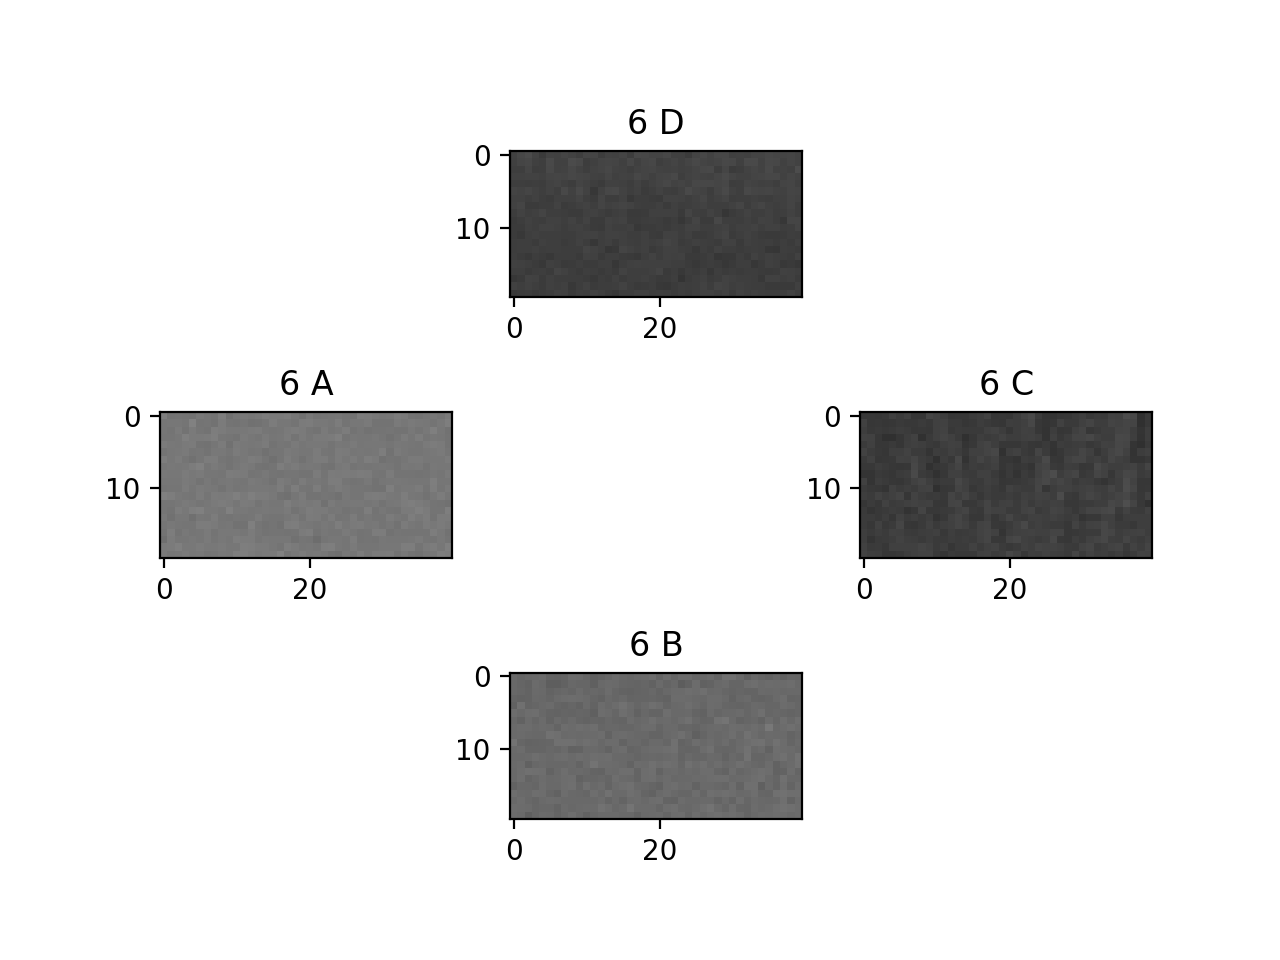

for segment  7
nx= 41
ny= 21
0 1 3.4813289916996593
0 2 -4.629520187639079
0 3 -6.20459661877503
1 2 -1.4217577467534241
1 3 -3.534802350097377
2 3 3.1279757988773
Correlation score = 9.81578235603206



<IPython.core.display.Javascript object>


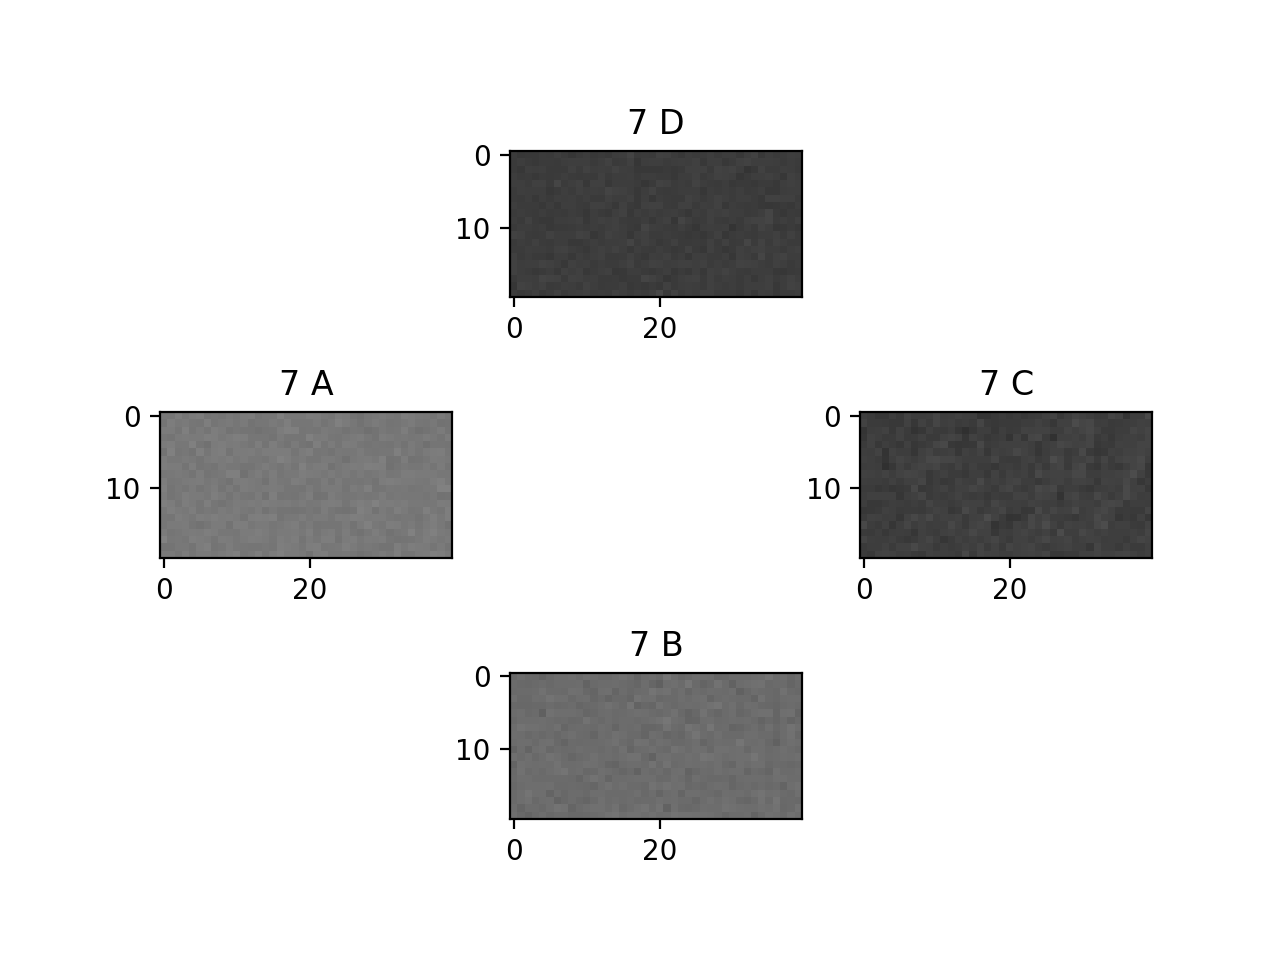

<IPython.core.display.Javascript object>


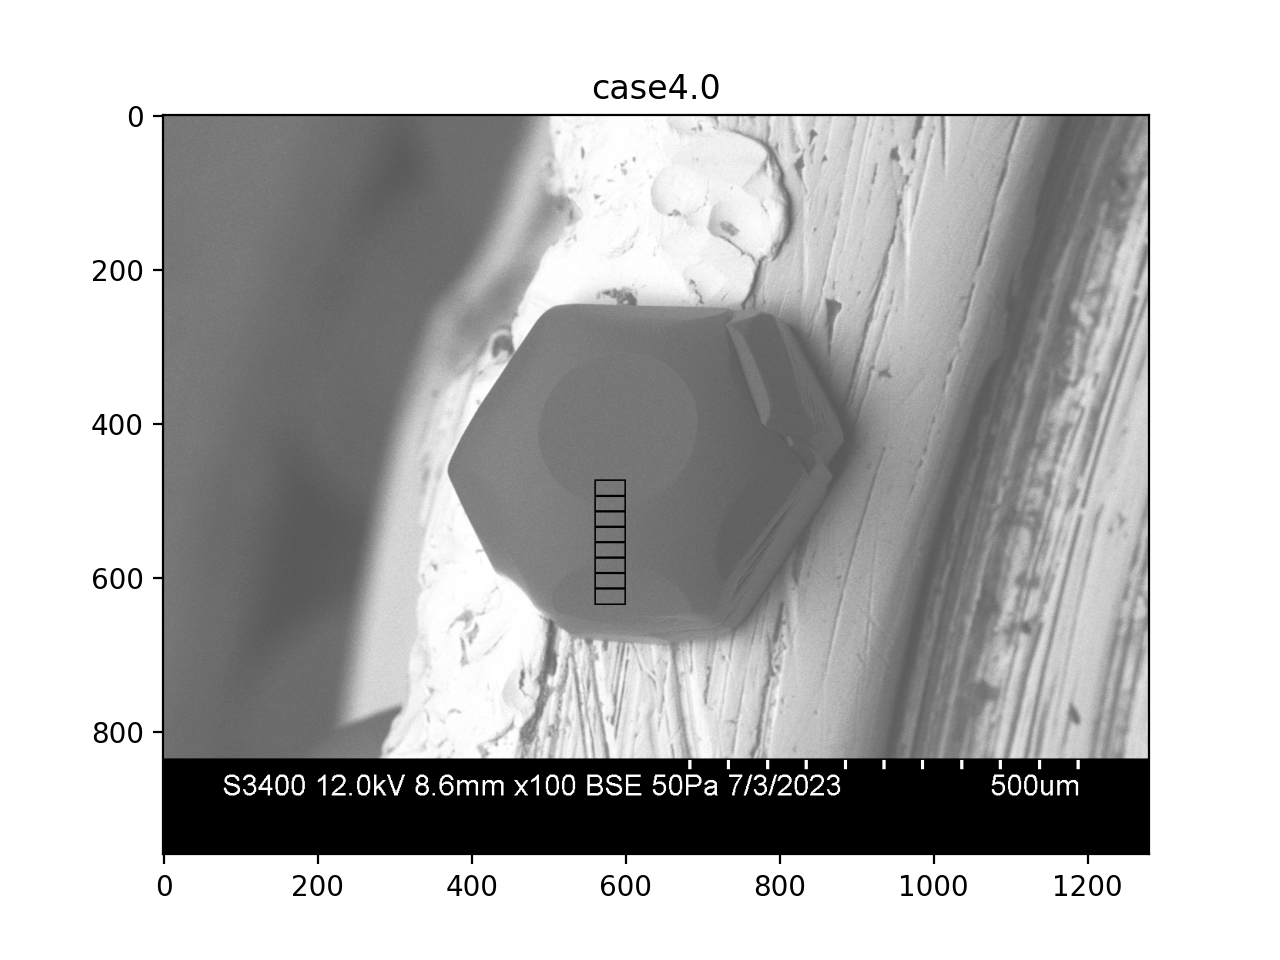

In [103]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [104]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

Calibration.nml


In [105]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [106]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [107]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [108]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [109]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [110]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [111]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 8 )
for 560 475
Observed intensities (detector B):
mean, max, min = 59.6025 69.0 51.0
<diff>, std(diff), di2 = 2.650963260763819 4.714654359465233 726.6192056724584
<diff>, std(diff), di2 = 2.76090241825126 3.9742795439781617 0.6037813964055394

Segment: 1 ( 2 of 8 )
for 560 495
Observed intensities (detector B):
mean, max, min = 61.98625 74.0 52.0
<diff>, std(diff), di2 = 3.2744007607638195 5.296276841343779 1352.6119506779103
<diff>, std(diff), di2 = 3.1839609515910148 4.210015083825823 2.89921764478759
Noverlap = 41

Segment: 2 ( 3 of 8 )
for 560 515
Observed intensities (detector B):
mean, max, min = 70.4575 81.0 60.0
<diff>, std(diff), di2 = 3.2737757607638196 8.426974520716392 7913.651329432666
<diff>, std(diff), di2 = 2.087129649269967 3.8389623404899234 44.33258906299905
<diff>, std(diff), di2 = 1.9961107359261843 3.8374238795998092 0.12294160456766624
Noverlap = 41

Segment: 3 ( 4 of 8 )
for 560 535
Observed intensities (detector B):
mean, max, min = 73.005 

40
160


<IPython.core.display.Javascript object>


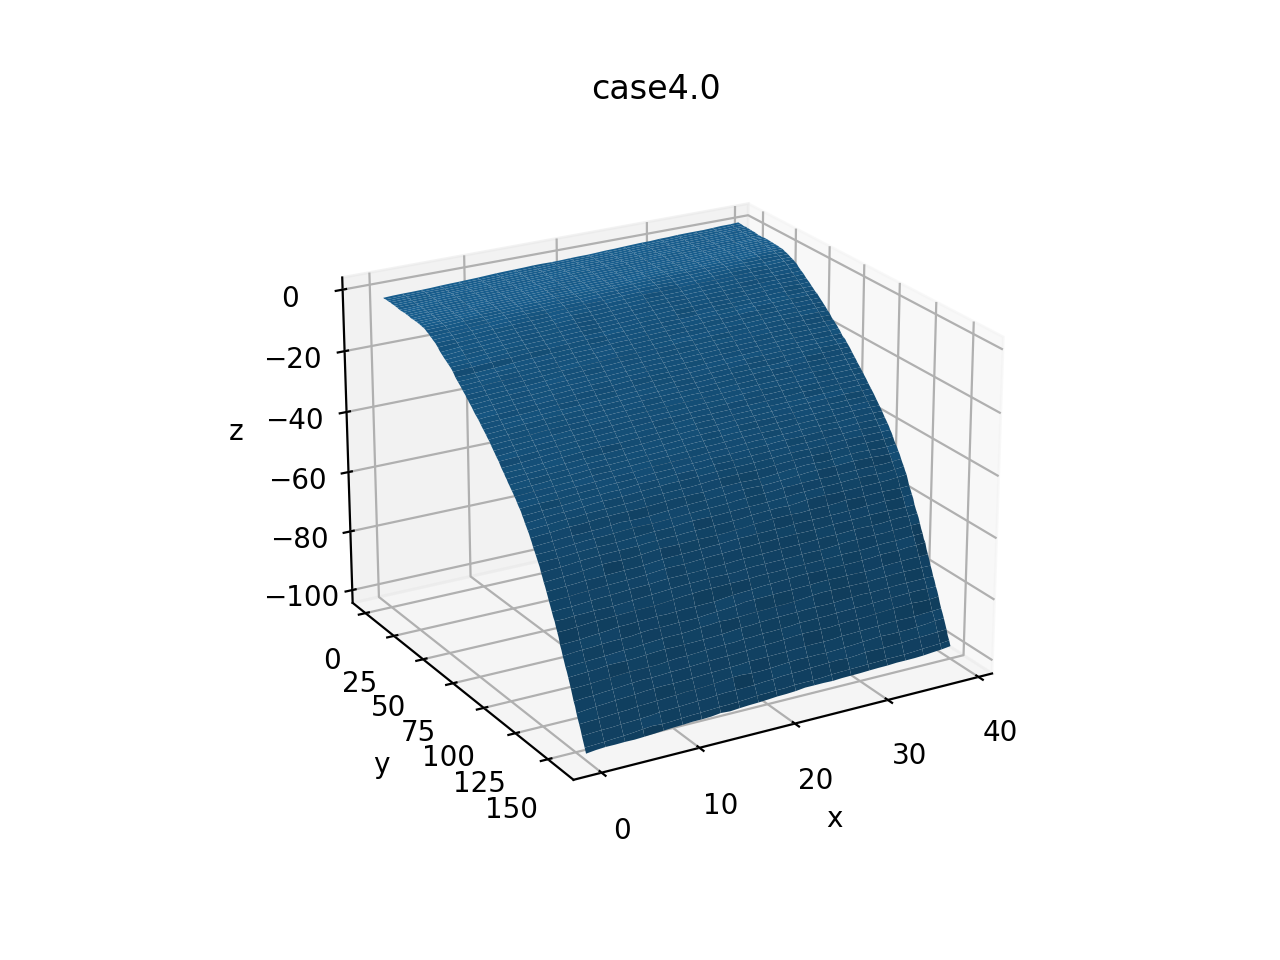

In [112]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [113]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments_calibrate_angle_retrieved
